#Detecting color with Python and OpenCV using HSV colorspace

Click Capture to take a photo for color detection


<IPython.core.display.Javascript object>

Result:


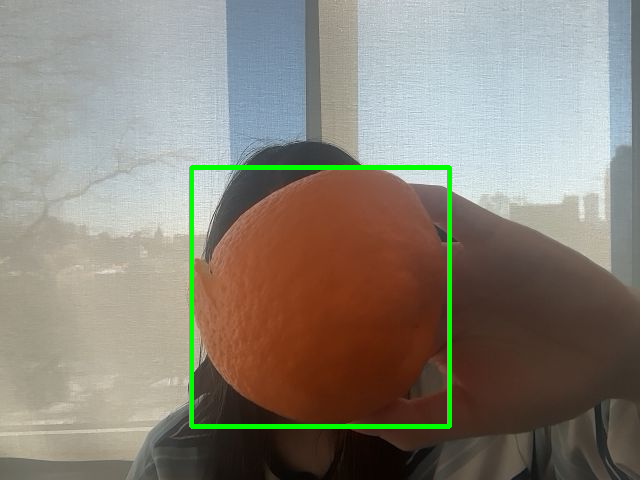

Mask:


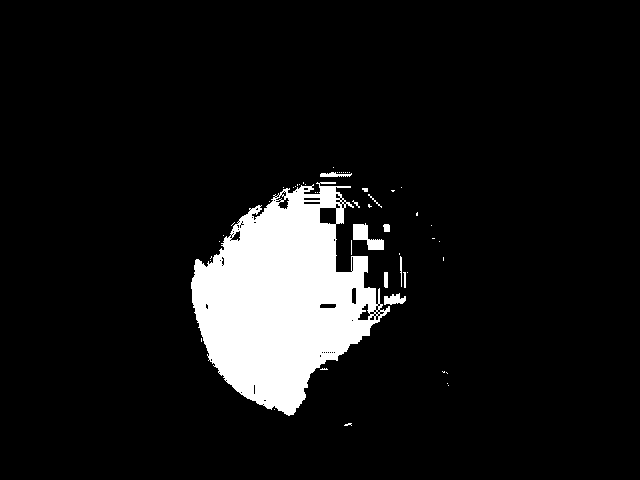

In [25]:
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def get_limits(color):
    c = np.uint8([[color]])  # BGR
    hsvC = cv2.cvtColor(c, cv2.COLOR_BGR2HSV)
    hue = hsvC[0][0][0]

    if hue >= 165:  # red wrap-around
        lower = np.array([hue - 10, 100, 100], dtype=np.uint8)
        upper = np.array([180, 255, 255], dtype=np.uint8)
    elif hue <= 15:
        lower = np.array([0, 100, 100], dtype=np.uint8)
        upper = np.array([hue + 10, 255, 255], dtype=np.uint8)
    else:
        lower = np.array([hue - 10, 100, 100], dtype=np.uint8)
        upper = np.array([hue + 10, 255, 255], dtype=np.uint8)

    return lower, upper

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  print("Click Capture to take a photo for color detection")
  filename = take_photo()

  # Read the captured image
  frame = cv2.imread(filename)

  # --- DETECTION LOGIC ---
  orange = [0, 165, 255]  # BGR
  hsvImage = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  lowerLimit, upperLimit = get_limits(color=orange)
  mask = cv2.inRange(hsvImage, lowerLimit, upperLimit)

  bbox = Image.fromarray(mask).getbbox()

  if bbox is not None:
      x1, y1, x2, y2 = bbox
      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

  # Display the results using Colab patch
  print("Result:")
  cv2_imshow(frame)
  print("Mask:")
  cv2_imshow(mask)

except Exception as err:
  print(f"Error: {err}")
